__Compressing an image__ 
---

[![colab image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/astro-informatics/s2scat/blob/main/notebooks/compression.ipynb)

This tutorial demonstrates how to compress a spherical image $f$ into a (relatively) small number of scattering covariance coefficients which, unlike other popular statistics, encode complex non-Gaussian structural information such as filaments.

Defining the scattering covariance operation as $\mathcal{S} : f \rightarrow \lbrace S \rbrace$ we will consider two basic variants: anisotropic coefficiets $S^{\text{ani}}$, which are more expressive but higher dimensionality, may be recovered by running $\mathcal{S}^{\text{ani}}$; anisotropic coefficiets $S^{\text{iso}}$, which are less expressive but much lower dimensionality, may be recovered by running $\mathcal{S}^{\text{iso}}$.

### So what's the difference? 

At highest order, anisotropic coefficients encode covariant information between 3 different wavelet scales $j$ and directions $n$. On the other hand, isotropic coefficients average over $n$ sampling the mean covariance structure across scales. Note that isotropic coefficients will still capture directional filamentary structure, but will be somewhat less expressive.

### What's the latent dimensionality? 

The maximum number of wavelet scales is determined by the bandlimit $L$ to be $J = \log_2L$, and the number of directions sampled is simply $2N-1$. So, putting this together for the highest order anisotropic coefficients the dimensionality is 

$$J(J-1)(J-2)N^3 \sim \ \mathcal{O}(J^3N^3) \sim \mathcal{O}(N^3\log_2L).$$

So increasing the number of directions can inflate this representation, however for almost all applications $N\leq3$ is entirely sufficient (finer directional information is captured through the covariance between coarser directions). For isotropic coefficients the number of coefficients is given by 

$$J(J-1)(J-2) \sim \ \mathcal{O}(J^3) \sim \mathcal{O}(\log_2L),$$

which is extremely compressed.

### Further notes

These compressed statistics still retain some nice features of the wavelets used to generate them. As we use wavelets on SO(3) we recover a representation which exhibits exact rotational equivariance on the sphere! One could therefore use scattering covariances to compress high resolution spherical images as a preprocessing step, before feeding this coefficients into e.g. a multilayer perceptron [(McEwen et al 2021)](https://arxiv.org/abs/2102.02828).


## Import the package

Lets first import ``S2SCAT`` and some basic packages.

In [1]:
import jax
jax.config.update("jax_enable_x64", True)

from matplotlib import pyplot as plt 
import numpy as np 

import s2scat

## Configure the problem

Lets set up the target field we are aiming to emulate, and the hyperparameters of the scattering covariance representation we will work with.

In [2]:
L = 128                # Spherical harmonic bandlimit.
N = 3                  # Azimuthal bandlimit (directionality).
J_min = 0              # Minimum wavelet scale.
reality = True         # Input signal is real.

# Lets load in the spherical field we wish to emulate and its harmonic coefficients.
f = np.load('data/WL_example_f_{}.npy'.format(L))
flm = np.load('data/WL_example_flm_{}.npy'.format(L))

What does $f$ actually look like? Lets just plot the equirectangular ($\theta,\varphi$) map

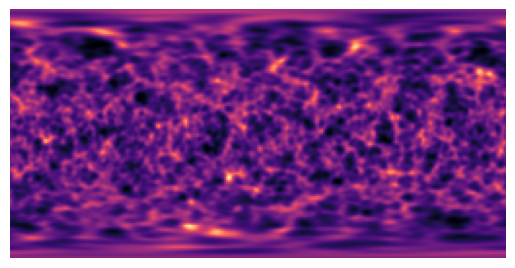

In [3]:
plt.imshow(f, cmap='magma')
plt.axis('off')
plt.show()

Before calling the scattering transform you need to run configuration, which will generate any precomputed arrays and cache them. When running the recurisve transform this shouldn't take much memory at all. However, the fully precompute transform can be extremely memory hungry at L ~ 512 and above!

In [4]:
config = s2scat.configure(L, N, J_min, reality)

## Compute anisotropic scattering covariances

Now all we have to do is apply ``S2SCAT`` to compute the statistics

In [5]:
covariances = s2scat.scatter(flm, L, N, J_min, reality, config)

So what is actually in this covariances Tuple? Essentially it is a list of:

- covariances[0]: The field mean.
- covariances[1]: The field variance.
- covariances[2]: The mean power in each direction (S1).
- covariances[3]: The mean power in each wavelet scale (P00).
- covariances[4]: The fourth order covariance between two wavelet scales and two directions, defined as 

$$ \text{C01} = \text{Cov} \big[\Psi^{\lambda_1} f, \Psi^{\lambda_1} | \Psi^{\lambda_2} f | \big] $$

- covariances[5]: The sixth order covariance between three wavelet scales and three directions, defined as 

$$ \text{C11} = \text{Cov}\big [ \Psi^{\lambda_1} | \Psi^{\lambda_3} f |, \Psi^{\lambda_1} | \Psi^{\lambda_2} f | \big ] $$

In [10]:
for i in range(6):
    print("Number of coefficients for anisotropic covariance[{}]: {}".format(i, covariances[i].shape))

Number of coefficients for covariance[0]: ()
Number of coefficients for covariance[1]: ()
Number of coefficients for covariance[2]: (40,)
Number of coefficients for covariance[3]: (40,)
Number of coefficients for covariance[4]: (700,)
Number of coefficients for covariance[5]: (17500,)


## Compute isotropic scattering covariances

Instead, lets now compute the isotropic version of these statistics

In [12]:
covariances = s2scat.scatter(flm, L, N, J_min, reality, config, isotropic=True)

which have much lower dimensionality

In [13]:
for i in range(6):
    print("Number of coefficients for isotropic covariance[{}]: {}".format(i, covariances[i].shape))

Number of coefficients for isotropic covariance[0]: ()
Number of coefficients for isotropic covariance[1]: ()
Number of coefficients for isotropic covariance[2]: (40,)
Number of coefficients for isotropic covariance[3]: (40,)
Number of coefficients for isotropic covariance[4]: (28,)
Number of coefficients for isotropic covariance[5]: (140,)


but still encode important non-Gaussian structural information!

## What next?

This compression may well be sufficient for e.g. Bayesian inference methods. However, at higher resolutions one may wish to go even further and consider applying PCA or machine learning method such as variational auto-encoders to compress further. 

In any case there are a number of use cases for the scattering covariances that extend beyond compression:

- emulation: It is possible to generate realisations of the original signal $f$ from scattering covariances. An overview for this is provided in the adjacent notebook.

- regularisation: It is possible to use this statistical representation to regularise e.g. inverse problems on the sphere. This works in precisely the same way that iterative Wiener filters condition on second order statistics through the power spectrum.